# Question 5

(a) Create 1,000 simulations with a sample size of 1,000 of the AR(3) process. For each simulation,
estimate an AR(1) process by OLS.
xt+1 = φxt + et+1
Plot the distribution for the estimate ˆφ, the autocorrelations, and the partial autocorrelations of
the residuals. What do you learn from the error ACF? Assess the properties of the estimated
parameters.

In [57]:
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [11]:
np.polynomial.polynomial.polyfromroots([0.8, 0.9, 0.95])

array([-0.684,  2.335, -2.65 ,  1.   ])

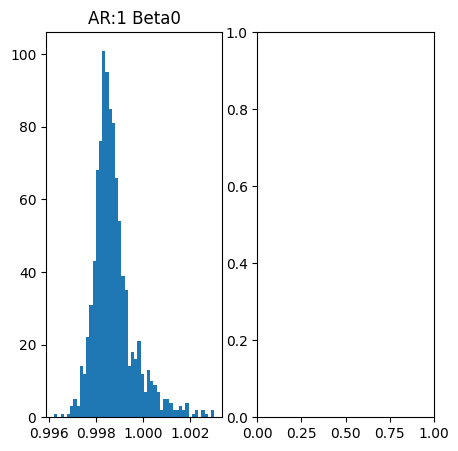

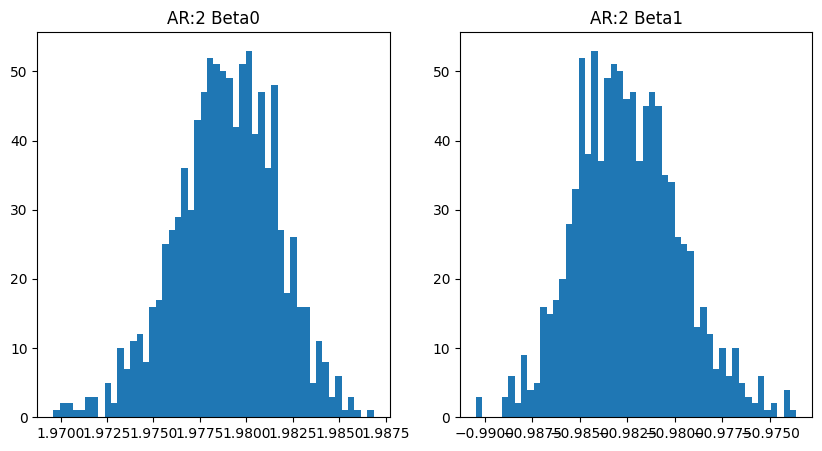

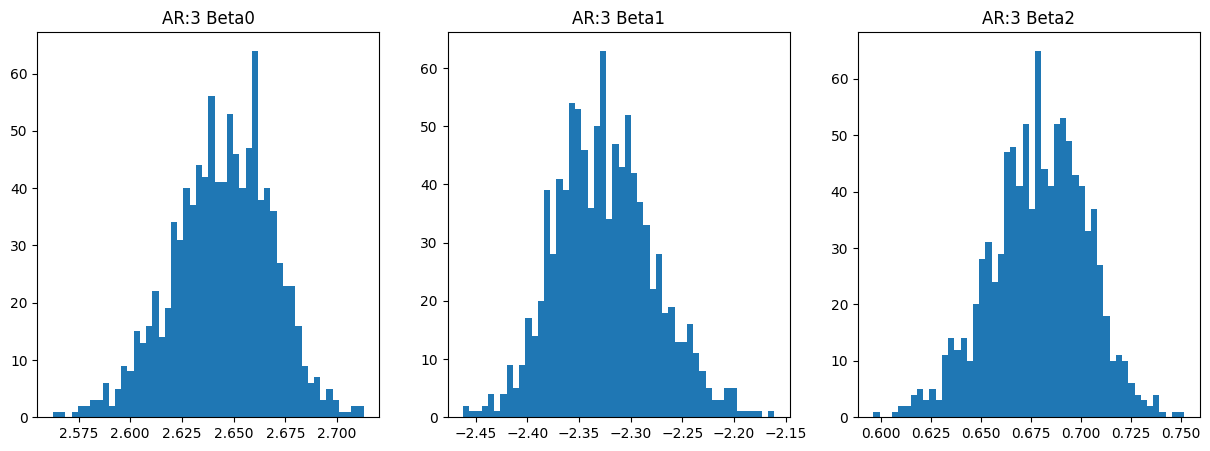

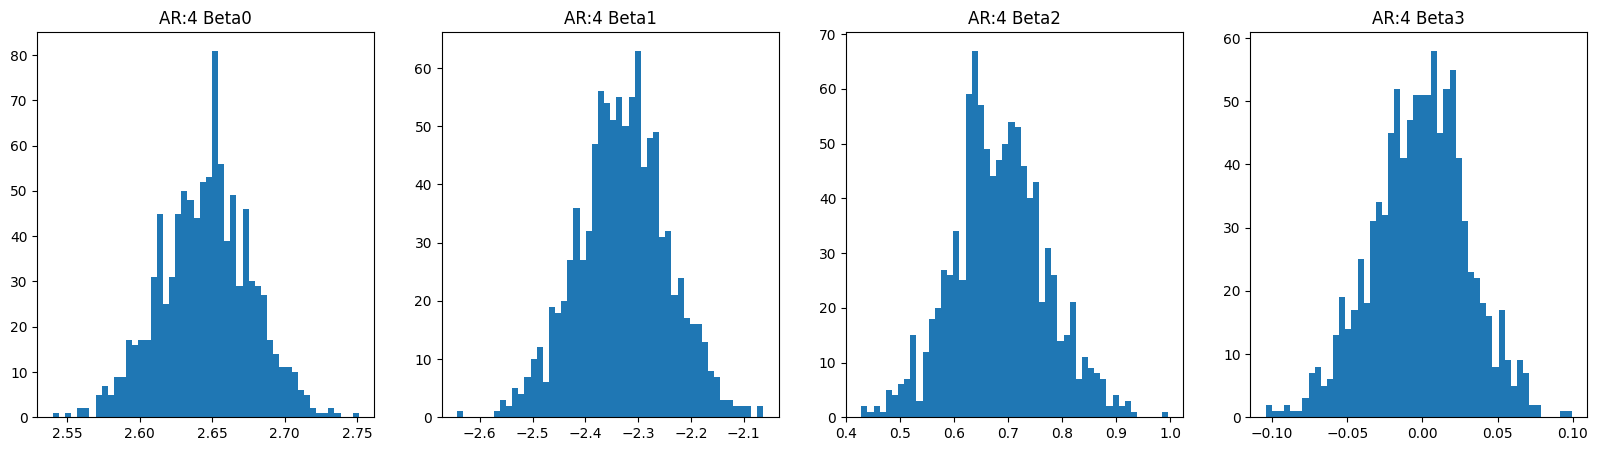

In [131]:
for i in range(1, 5):

    betas = []
    for _ in range(1000):
        data = sm.tsa.arma_generate_sample([1, -2.65, 2.335, -0.684], [1] ,1000)
        res = AutoReg(data, lags=i).fit()
        betas.append(res.params)

    betas = np.array(betas).T
    fig, ax = plt.subplots(nrows=1, ncols=max(2,i), figsize=(5*i,5))
    for j, b in enumerate(betas[1:]):
        ax[j].hist(b, bins=50)
        ax[j].set_title(f"AR:{i} Beta{j}")
    fig.show()


From observing the distributions of the model parameters, we can see that when fitting too few coefficients we get large changes in the coefficient values; however, once we surpass the true order the additional coeficients average out to zero. 

# Question 6

In [36]:
betas = []

for _ in range(1000):
    x1 = np.random.normal(0, 1, 1000)
    x2 = np.random.normal(0, 1, 1000)
    y = x1 + x2 + np.random.normal(0, 1, 1000)

    res = sm.OLS(y, x1).fit()
    betas.append(res.params[0])

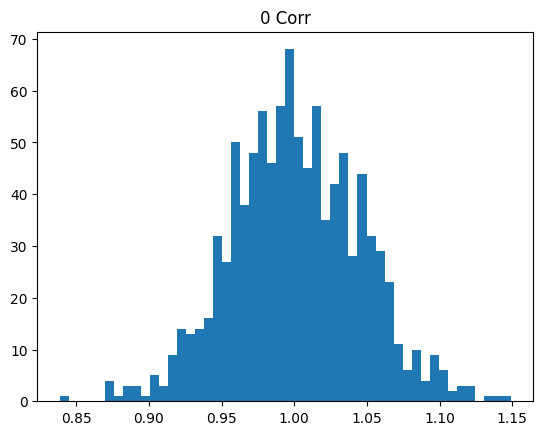

STD: 0.04461913297778077
STD: 1.0012815716728432


In [37]:
plt.hist(betas, bins=50)
plt.title("0 Corr")
plt.show()

print(f'STD: {np.std(betas)}')
print(f'STD: {np.mean(betas)}')

In this case the regression meets all assumptions EXCEPT for exogeneity. I.E we have omitted variable bias in our model due to missing one of the regressors, and without a constants we are unable to correct for the mean of the missing variable. By coincidence the bias is not visible in this case.

In [38]:
betas = []

for _ in range(1000):
    x1, x2 = np.random.multivariate_normal([0,0], [[1,0.5],[0.5,1]], size=1000).T
    y = x1 + x2 + np.random.normal(0, 1, 1000)
    
    res = sm.OLS(y, x1).fit()
    betas.append(res.params[0])

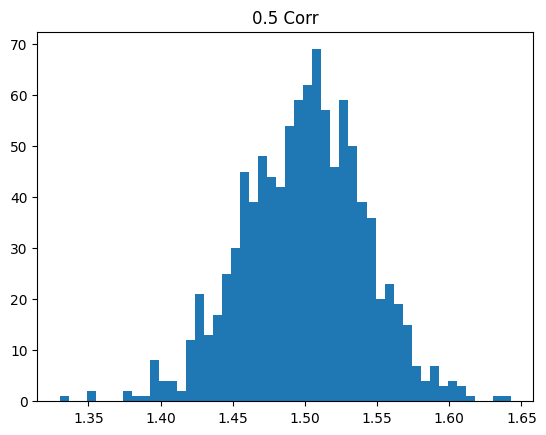

STD: 0.042387310473346984
STD: 1.4994497348953166


In [39]:
plt.hist(betas, bins=50)
plt.title("0.5 Corr")
plt.show()

print(f'STD: {np.std(betas)}')
print(f'STD: {np.mean(betas)}')

In [40]:
betas = []

for _ in range(1000):
    x1, x2 = np.random.multivariate_normal([0,0], [[1, -0.5],[-0.5, 1]], size=1000).T
    y = x1 + x2 + np.random.normal(0, 1, 1000)
    
    res = sm.OLS(y, x1).fit()
    betas.append(res.params[0])

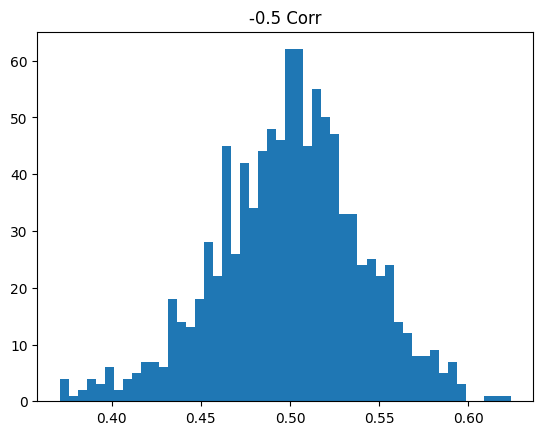

STD: 0.0409361755517281
STD: 0.49959174726455813


In [41]:
plt.hist(betas, bins=50)
plt.title("-0.5 Corr")
plt.show()

print(f'STD: {np.std(betas)}')
print(f'STD: {np.mean(betas)}')

After giving the variables a certain correlation we see that the mean and standard deviation gets moved in that direction. We see mean and std increase with positive correlation and decrease with negative correlation. In each case we see how an omitted variable is throwing off the true coefficient of the regression.

# Question 7

In [44]:
df = pd.read_csv("TB3MS.csv")

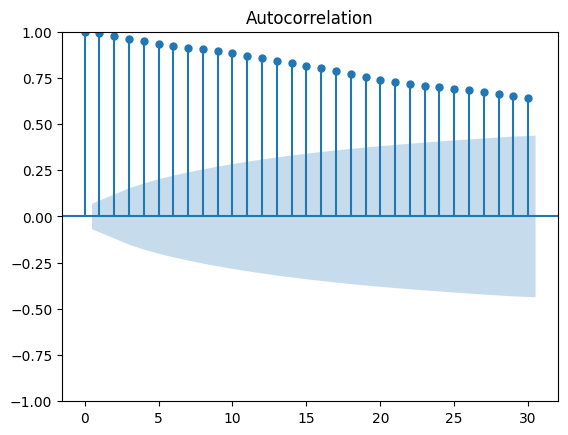

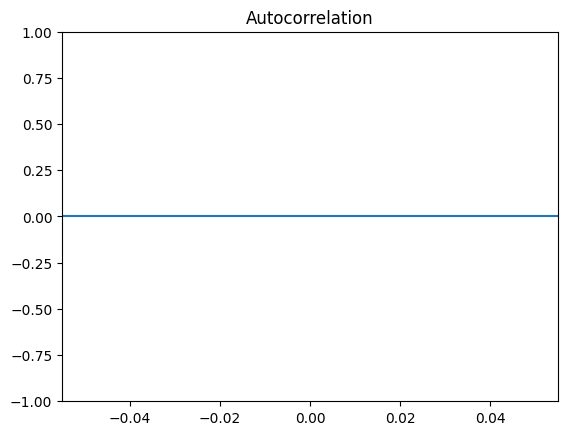

In [67]:
_=plot_acf(df.iloc[:,1])
_=plot_acf(df.iloc[:,1].diff(1))

We can clearly see that this series is not stationary in its default state. However, after 1 differencing it seems to become completeley uncorrelated. 

In [87]:
res = sm.tsa.arima.ARIMA(df.iloc[:,1], order=(5,1,1)).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  TB3MS   No. Observations:                  806
Model:                 ARIMA(5, 1, 1)   Log Likelihood                -341.943
Date:                Mon, 08 Apr 2024   AIC                            697.886
Time:                        15:17:43   BIC                            730.722
Sample:                             0   HQIC                           710.496
                                - 806                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3406      0.053     -6.401      0.000      -0.445      -0.236
ar.L2          0.0879      0.026      3.373      0.001       0.037       0.139
ar.L3         -0.1111      0.023     -4.826      0.000      -0.156      -0.066
ar.L4         -0.0296      0.020     -1.519      0.129      -0.068       0.009
ar.L5          0.0923      0.017      5.492      0.000       0.059       0.125
ma.L1          0.7755      0.051     15.278      0.000       0.676       0.875
sigma2         0.1369      0.003     52.755      0.000       0.132       0.142
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):             11832.94
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               0.28   Skew:                            -1.60
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [106]:
from itertools import product

bics = []
for ord in product(range(0,10),range(0,3),range(0,10)):
    res = sm.tsa.arima.ARIMA(df.iloc[:,1], order=ord).fit()
    bics.append((ord, res.aic, res.bic))
            

In [121]:
sorted(bics, key=lambda x: x[1])

[((9, 1, 6), 628.5228997951604, 703.5763762338573),
 ((9, 1, 4), 629.4872159471801, 695.15900783104),
 ((9, 1, 3), 631.2448486140639, 692.2257982205052),
 ((9, 1, 2), 632.0123692995138, 688.3024766285366),
 ((9, 2, 9), 633.7879840168226, 722.890370131223),
 ((9, 2, 6), 633.8639351577485, 708.897523464612),
 ((8, 1, 7), 635.5302360944794, 710.5837125331764),
 ((9, 2, 8), 635.6435145041482, 720.0563013493696),
 ((7, 1, 7), 635.7884133930029, 706.1510475542814),
 ((9, 0, 5), 635.8258448404022, 710.8991847205082),
 ((7, 1, 8), 636.1232872779076, 711.1767637166046),
 ((7, 1, 9), 636.2175493625786, 715.9618680786941),
 ((6, 1, 8), 636.4266585048315, 706.78929266611),
 ((8, 0, 9), 636.7847108744259, 725.9343019820518),
 ((4, 1, 9), 637.2467470117833, 702.9185388956432),
 ((8, 2, 6), 637.305125064066, 707.6491141017506),
 ((5, 1, 9), 637.3360915441297, 707.6987257054082),
 ((8, 1, 8), 637.6545174165076, 717.3988361326232),
 ((9, 0, 6), 638.7062584695748, 718.4716820921874),
 ((6, 1, 7), 638.86

In [122]:
sorted(bics, key=lambda x: x[2])

[((9, 1, 2), 632.0123692995138, 688.3024766285366),
 ((9, 1, 3), 631.2448486140639, 692.2257982205052),
 ((9, 1, 1), 643.0022700738376, 694.6015351254418),
 ((5, 1, 5), 643.4457292120069, 695.0449942636111),
 ((9, 1, 4), 629.4872159471801, 695.15900783104),
 ((7, 1, 2), 649.1477984028828, 696.0562211770684),
 ((9, 1, 0), 649.6628350604461, 696.5712578346318),
 ((6, 1, 2), 654.4188323812803, 696.6364128780473),
 ((6, 1, 3), 651.1310031271959, 698.0394259013815),
 ((2, 1, 6), 656.3073157041921, 698.5248962009591),
 ((6, 1, 4), 647.1994988378254, 698.7987638894297),
 ((8, 1, 0), 656.8362244948413, 699.0538049916083),
 ((8, 1, 1), 653.542546179718, 700.4509689539036),
 ((6, 1, 0), 668.0225203237528, 700.8584162656828),
 ((4, 1, 5), 654.0998374272685, 701.0082602014542),
 ((9, 2, 3), 640.6297525052041, 701.5945430045307),
 ((6, 1, 5), 645.358238121835, 701.6483454508577),
 ((7, 1, 3), 650.20787310441, 701.8071381560143),
 ((8, 1, 2), 650.9381948219209, 702.5374598735251),
 ((6, 1, 6), 641.5

From the parameter combinations tested I recieved the best results with: (9, 1, 2),  sorting by BIC: 688.3024766285366.
When using AIC I got: (9, 1, 6) AIC: 628.52289

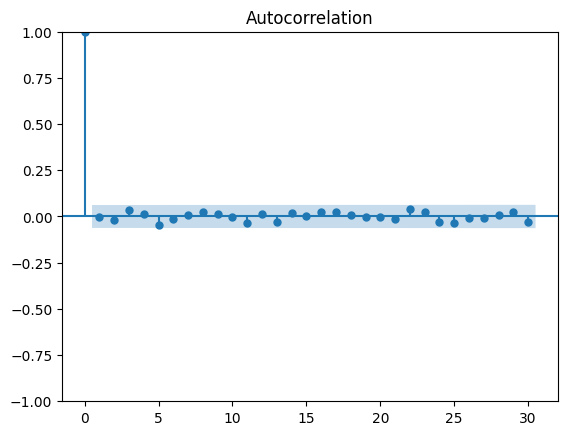

In [128]:
sm.tsa.arima.ARIMA(df.iloc[:,1], order=(9, 1, 2)).fit()
_=plot_acf(res.resid)

(array([ 10.,  39., 106., 174., 229., 213., 135.,  64.,  18.,   8.]),
 array([-2.86577583, -2.26140544, -1.65703505, -1.05266467, -0.44829428,
         0.1560761 ,  0.76044649,  1.36481687,  1.96918726,  2.57355765,
         3.17792803]),
 <BarContainer object of 10 artists>)

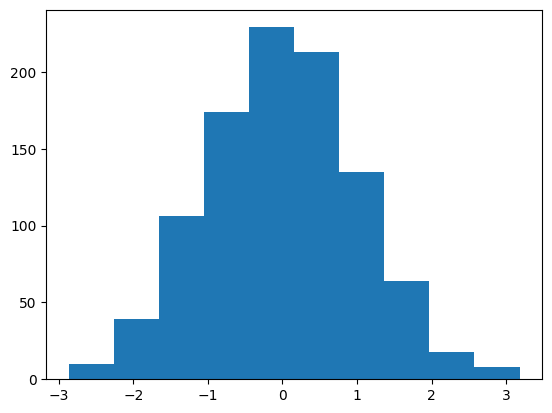

In [129]:
plt.hist(res.resid)

Looking at the histogram and ACF of the residuals I do not see anything alarming.